# Health Insurance Price Forecast

# Libraries and Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

import pickle

In [2]:
# source: https://github.com/empathy87/storytelling-with-data

# colors
GRAY1, GRAY2, GRAY3 = '#231F20', '#414040', '#555655'
GRAY4, GRAY5, GRAY6 = '#646369', '#76787B', '#828282'
GRAY7, GRAY8, GRAY9 = '#929497', '#A6A6A5', '#BFBEBE'
BLUE1, BLUE2, BLUE3, BLUE4 = '#174A7E', '#4A81BF', '#94B2D7', '#94AFC5'
RED1, RED2 = '#C3514E', '#E6BAB7'
GREEN1, GREEN2 = '#0C8040', '#9ABB59'
ORANGE1 = '#F79747'

# fonts
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.bf'] = 'Arial:bold'
plt.rcParams['mathtext.it'] = 'Arial:italic'

In [3]:
# setting random state
rs = 42847

# Functions

In [4]:
def run_model(model, print_values = 1, return_predictions = 0):
    """
    Function that receives a machine learning model and returns its metrics.
    
    print_values = 1: print the results of the calculated metrics
    return_predictions = 1: returns the y predictions together with the metrics
    """
    model.fit(X_train, y_train)
    y_predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_predictions)
    mse = mean_squared_error(y_test, y_predictions)
    rmse = np.sqrt(mse)
    if print_values:
        print(f"MAE: {round(mae, 3)}")
        print(f"MSE: {round(mse, 3)}")
        print(f"RMSE: {round(rmse, 3)}")
    if return_predictions:
        return y_predictions, mae, mse, rmse
    return mae, mse, rmse

# Data Checking and Cleaning

Let's first load our data. It was downloaded from [the Kaggle problem page](https://www.kaggle.com/mirichoi0218/insurance) and uploaded to GitHub for easy access.

In [6]:
df = pd.read_csv('insurance.csv')

Checking the first few line of the dataset:

In [7]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


From this we see that we have the following information (adapted from the Kaggle problem description):
- **age**: age of primary beneficiary;
- **sex**: insurance contractor gender, female, male;
- **bmi**: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight $(kg/m^2)$ using the ratio of height to weight, ideally 18.5 to 24.9;
- **children**: Number of children covered by health insurance / Number of dependents;
- **smoker**: if that person smokes or not;
- **region**: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest;
- **charges**: Individual medical costs billed by health insurance.

In [9]:
print(f'Numer of rows: {df.shape[0]}')
print(f'Numer of columns: {df.shape[1]}')

Numer of rows: 1338
Numer of columns: 7


Let's check missing values:

In [8]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Since this is a Kaggle dataset, it is already pretty clean.

Information about the columns:

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Statistics about the values:

In [9]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


From this we see that the youngest person in the dataset is 18 years old and the oldes, 64 years old.

The average BMI is around 30.66, which is pretty high compared to the ideal BMI of 18.5 to 24.9.

The person that has most children in this dataset has 5 children.

The lowest insurance charge is 1121.87 USD and the highest is 63770.42 USD.

# Exploratory Data Analysis

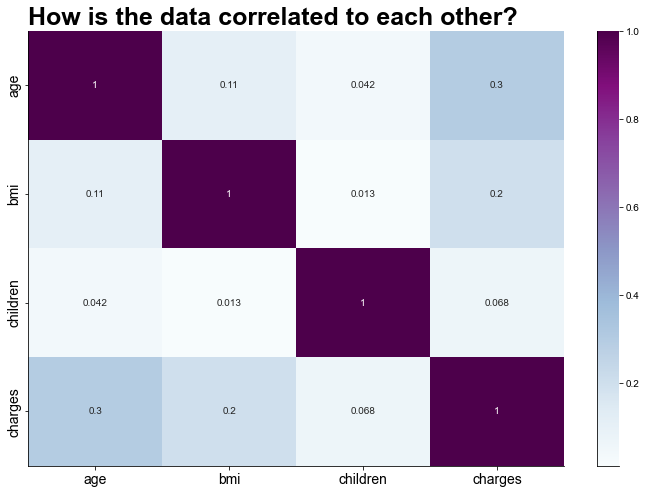

In [28]:
plt.figure(figsize = (12, 8))
sns.heatmap(df.corr(), cmap = "BuPu", annot = True)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('How is the data correlated to each other?', fontdict = {'fontsize': 25, 'fontweight': 'bold'}, loc = 'left')
sns.despine()
plt.show()

There's not really a significant correlation between the numerical information.

Let's now check the distribution of the variables.

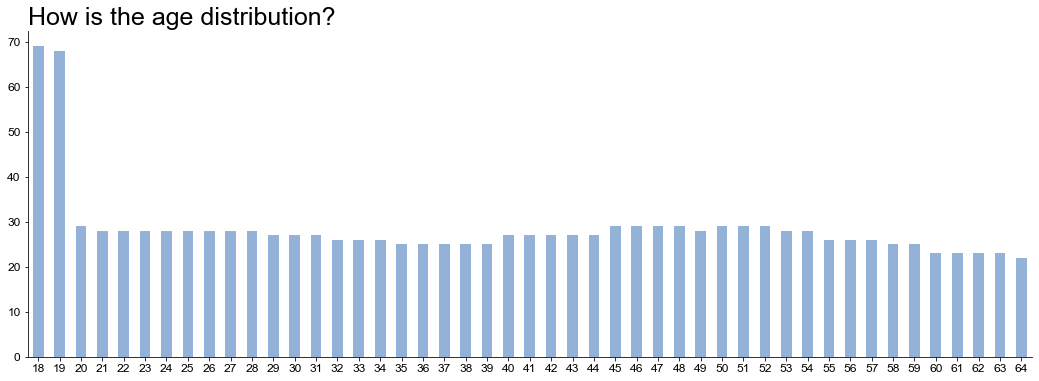

In [54]:
df.age.value_counts().sort_index(ascending = True).plot(kind = 'bar', figsize = (18, 6), color = BLUE3)
plt.title('How is the age distribution?', fontdict = {'fontsize': 25, 'fontweight': 'medium'}, loc = 'left')
plt.xticks(rotation = 0, fontsize = 12)
plt.yticks(fontsize = 12)
sns.despine()
plt.show()

It seems that the are approximately 30 people with each age, except for 18 and 19 years old, which seems to have almost 70 people each.

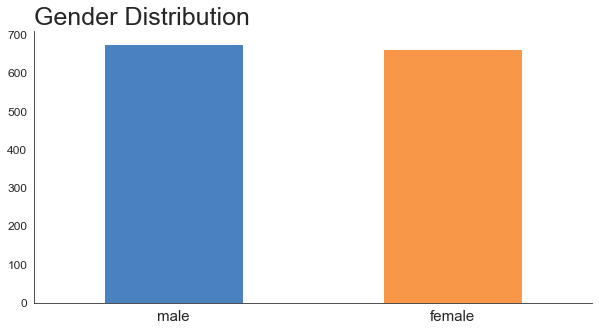

In [107]:
df.sex.value_counts().plot(kind = 'bar', figsize = (10, 5), color = [BLUE2, ORANGE1])
plt.title('Gender Distribution', fontdict = {'fontsize': 25, 'fontweight': 'medium'}, loc = 'left')
plt.xticks(rotation = 0, fontsize = 15)
plt.yticks(fontsize = 12)
sns.despine()
plt.show()

The distribution is almost 50-50. Let's check:

In [73]:
percentage_female = (df['sex'] == 'female').sum() / len(df) * 100
percentage_male = (df['sex'] == 'male').sum() / len(df) * 100

print(f'Percentage of female: {round(percentage_female, 2)}%')
print(f'Percentage of male: {round(percentage_male, 2)}%')

Percentage of female: 49.48%
Percentage of male: 50.52%


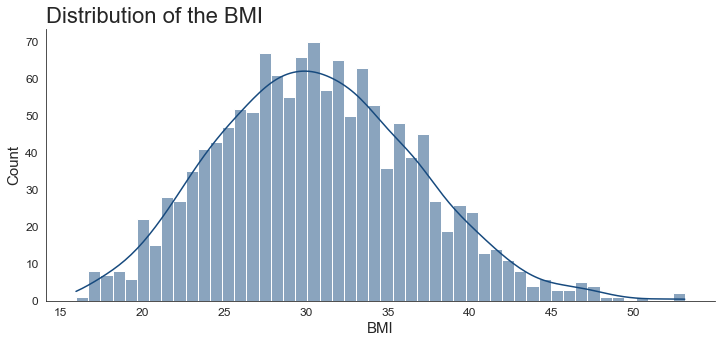

In [104]:
plt.figure(figsize = (12, 5))
plt.title("Distribution of the BMI", fontdict = {'fontsize': 22, 'fontweight': 'medium'}, loc = 'left')
sns.set_style("white")
ax = sns.histplot(df.bmi, kde = True, bins = 50, color = BLUE1)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('BMI', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
sns.despine()
plt.show()

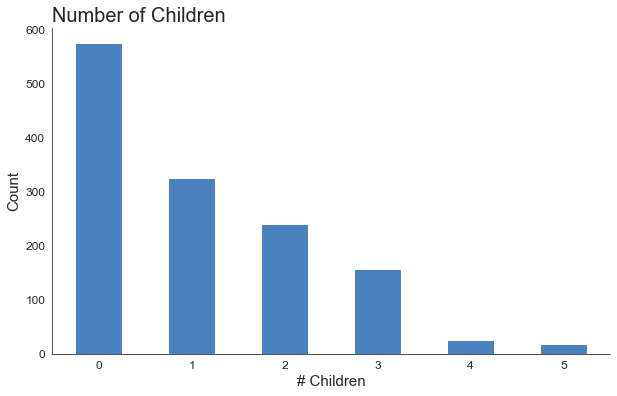

In [103]:
df.children.value_counts().sort_index().plot(kind = 'bar', figsize = (10, 6), color = BLUE2)
plt.title('Number of Children', fontdict = {'fontsize': 20, 'fontweight': 'medium'}, loc = 'left')
plt.xticks(rotation = 0, fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('# Children', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
sns.despine()
plt.show()

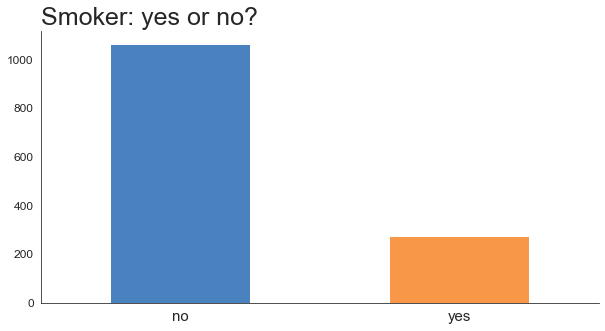

In [108]:
df.smoker.value_counts().plot(kind = 'bar', figsize = (10, 5), color = [BLUE2, ORANGE1])
plt.title('Smoker: yes or no?', fontdict = {'fontsize': 25, 'fontweight': 'medium'}, loc = 'left')
plt.xticks(rotation = 0, fontsize = 15)
plt.yticks(fontsize = 12)
sns.despine()
plt.show()

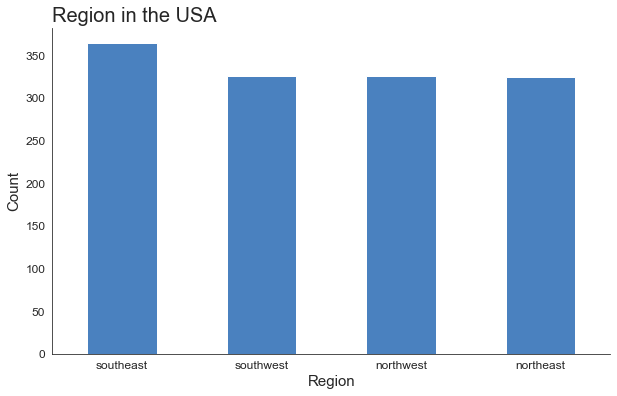

In [110]:
df.region.value_counts().plot(kind = 'bar', figsize = (10, 6), color = BLUE2)
plt.title('Region in the USA', fontdict = {'fontsize': 20, 'fontweight': 'medium'}, loc = 'left')
plt.xticks(rotation = 0, fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Region', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
sns.despine()
plt.show()

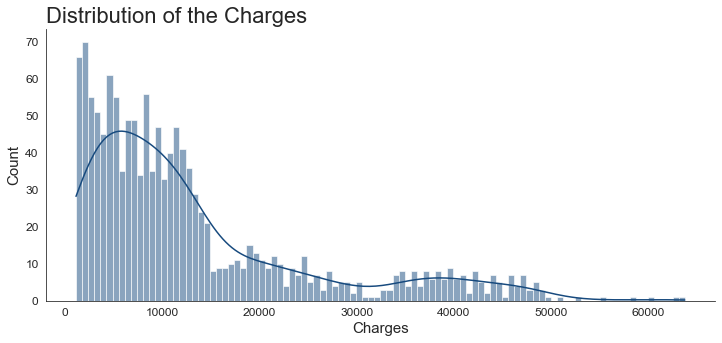

In [116]:
plt.figure(figsize = (12, 5))
plt.title("Distribution of the Charges", fontdict = {'fontsize': 22, 'fontweight': 'medium'}, loc = 'left')
sns.set_style("white")
ax = sns.histplot(df.charges, kde = True, bins = 100, color = BLUE1)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Charges', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
sns.despine()
plt.show()

It seems that our data is pretty well distributed in the region, sex and smoker categories.

Now let's check each variable against the charges to see how they realte.

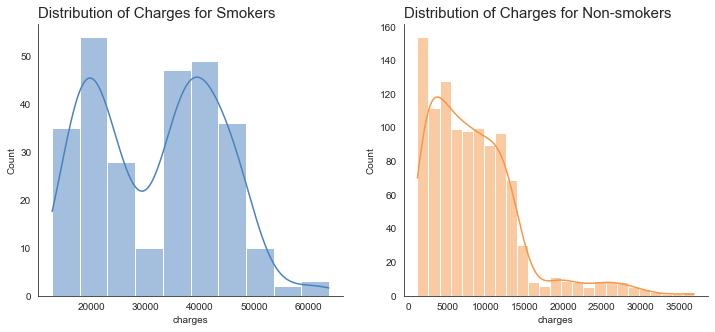

In [127]:
fig = plt.figure(figsize = (12, 5))

ax = fig.add_subplot(121)
sns.histplot(df[(df.smoker == 'yes')]['charges'], color = BLUE2, ax = ax, kde = True)
ax.set_title('Distribution of Charges for Smokers', fontdict = {'fontsize': 15, 'fontweight': 'medium'}, loc = 'left')

ax = fig.add_subplot(122)
sns.histplot(df[(df.smoker == 'no')]['charges'], color = ORANGE1, ax = ax, kde = True)
ax.set_title('Distribution of Charges for Non-smokers', fontdict = {'fontsize': 15, 'fontweight': 'medium'}, loc = 'left')

sns.despine()

plt.show()

We see that the charges are significantly higher for smokers.

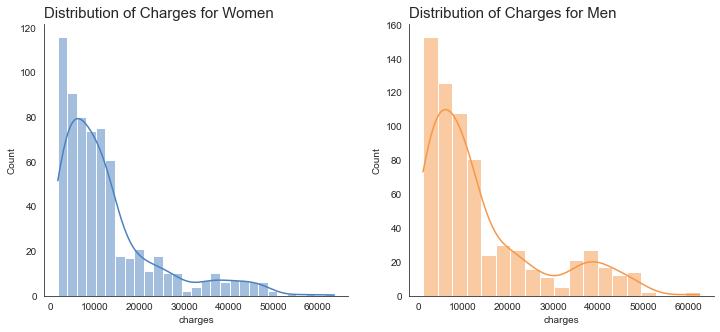

In [129]:
fig = plt.figure(figsize = (12, 5))

ax = fig.add_subplot(121)
sns.histplot(df[(df.sex == 'female')]['charges'], color = BLUE2, ax = ax, kde = True)
ax.set_title('Distribution of Charges for Women', fontdict = {'fontsize': 15, 'fontweight': 'medium'}, loc = 'left')

ax = fig.add_subplot(122)
sns.histplot(df[(df.sex == 'male')]['charges'], color = ORANGE1, ax = ax, kde = True)
ax.set_title('Distribution of Charges for Men', fontdict = {'fontsize': 15, 'fontweight': 'medium'}, loc = 'left')

sns.despine()

plt.show()

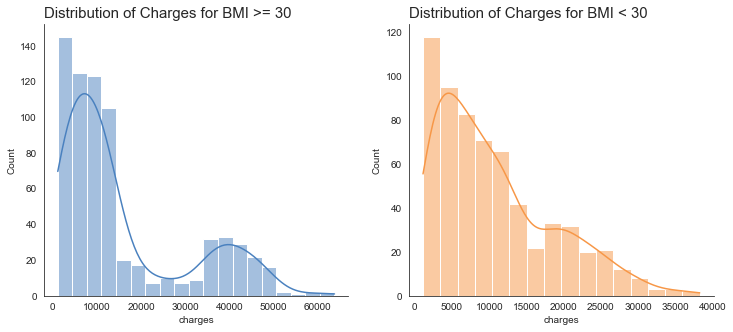

In [134]:
fig = plt.figure(figsize = (12, 5))

ax = fig.add_subplot(121)
sns.histplot(df[(df.bmi >= 30)]['charges'], color = BLUE2, ax = ax, kde = True)
ax.set_title('Distribution of Charges for BMI >= 30', fontdict = {'fontsize': 15, 'fontweight': 'medium'}, loc = 'left')

ax = fig.add_subplot(122)
sns.histplot(df[(df.bmi < 30)]['charges'], color = ORANGE1, ax = ax, kde = True)
ax.set_title('Distribution of Charges for BMI < 30', fontdict = {'fontsize': 15, 'fontweight': 'medium'}, loc = 'left')

sns.despine()

plt.show()

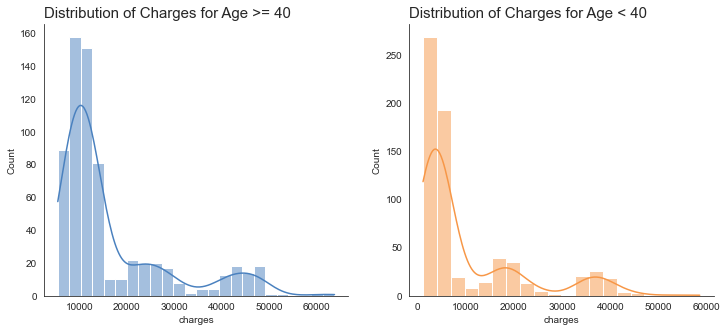

In [139]:
fig = plt.figure(figsize = (12, 5))

ax = fig.add_subplot(121)
sns.histplot(df[(df.age >= 40)]['charges'], color = BLUE2, ax = ax, kde = True)
ax.set_title('Distribution of Charges for Age >= 40', fontdict = {'fontsize': 15, 'fontweight': 'medium'}, loc = 'left')

ax = fig.add_subplot(122)
sns.histplot(df[(df.age < 40)]['charges'], color = ORANGE1, ax = ax, kde = True)
ax.set_title('Distribution of Charges for Age < 40', fontdict = {'fontsize': 15, 'fontweight': 'medium'}, loc = 'left')

sns.despine()

plt.show()

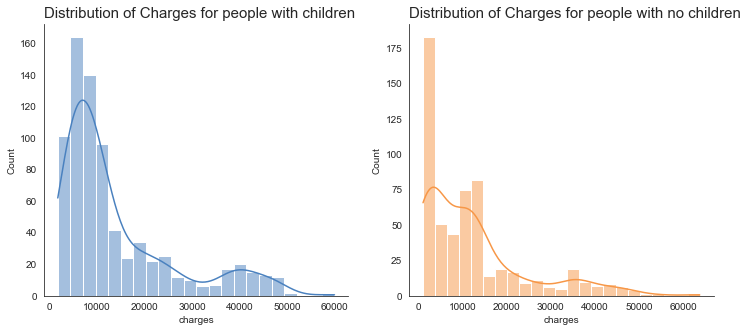

In [141]:
fig = plt.figure(figsize = (12, 5))

ax = fig.add_subplot(121)
sns.histplot(df[(df.children > 0)]['charges'], color = BLUE2, ax = ax, kde = True)
ax.set_title('Distribution of Charges for people with children', fontdict = {'fontsize': 15, 'fontweight': 'medium'}, loc = 'left')

ax = fig.add_subplot(122)
sns.histplot(df[(df.children == 0)]['charges'], color = ORANGE1, ax = ax, kde = True)
ax.set_title('Distribution of Charges for people with no children', fontdict = {'fontsize': 15, 'fontweight': 'medium'}, loc = 'left')

sns.despine()

plt.show()

# Feature Importance

# Model Prediction

## Preparation

In [19]:
df.sex = df.sex.map({"female": 1, "male": 0})
df.region = df.region.map({'southwest': 0, 'southeast': 1, 'northwest': 2, 'northeast': 3})
df.smoker = df.smoker.map({"yes": 1, "no": 0})

In [20]:
# df = pd.get_dummies(df, columns = ['sex', 'region', 'smoker'])

In [21]:
X = df.drop('charges', axis = 1)
y = df.charges

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = rs)

In [23]:
print(f'X train size: {len(X_train)} || y train size: {len(y_train)}')
print(f'X test size: {len(X_test)} || y train size: {len(y_test)}')

X train size: 1003 || y train size: 1003
X test size: 335 || y train size: 335


## 00 Dummy Model

In [24]:
dummy = DummyRegressor(strategy = 'mean')

In [25]:
mae_dummy, mse_dummy, rmse_dummy = run_model(dummy)

MAE: 9668.122
MSE: 174387341.422
RMSE: 13205.58


## 01 Linear Regression

In [26]:
linreg = LinearRegression()

In [27]:
mae_linreg, mse_linreg, rmse_linreg = run_model(linreg)

MAE: 4532.344
MSE: 43075124.028
RMSE: 6563.164


## 02 RandomForestRegressor

In [28]:
randomreg = RandomForestRegressor(random_state = rs)

In [29]:
mae_rfr, mse_rfr, rmse_rfr = run_model(randomreg)

MAE: 2766.848
MSE: 27880108.916
RMSE: 5280.162


### RandomForestRegressor Tuning

In [30]:
randomreg = RandomForestRegressor(random_state = rs)

params = {
    'n_estimators': [10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 4, 8],
    'bootstrap': [True, False]
}

rfr_search = GridSearchCV(randomreg,
                          params, 
                          scoring = 'neg_root_mean_squared_error',
                          error_score = 'raise',
                          n_jobs = -1,
                          verbose = 0,
                          cv = 5)

rfr_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=RandomForestRegressor(random_state=42847), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [10, 20, 30]},
             scoring='neg_root_mean_squared_error')

In [31]:
rfr_search.best_params_

{'bootstrap': True,
 'max_features': 'auto',
 'min_samples_split': 8,
 'n_estimators': 30}

In [32]:
rfr_model = rfr_search.best_estimator_
mae_rfr, mse_rfr, rmse_rfr = run_model(rfr_model)

MAE: 2720.655
MSE: 26969677.322
RMSE: 5193.234


## 03 Ridge Regression

In [33]:
ridge = Ridge(random_state = rs)
mae_ridge, mse_ridge, rmse_ridge = run_model(ridge)

MAE: 4542.96
MSE: 43100886.662
RMSE: 6565.127


### Ridge Regression Tuning

In [34]:
for i in [0.001, 0.01, 0.1, 0.5, 1.0, 10, 100]:
    ridge = Ridge(random_state = rs, alpha = i)
    print(f'alpha = {i}')
    run_model(ridge)
    print("---")

alpha = 0.001
MAE: 4532.355
MSE: 43075145.574
RMSE: 6563.166
---
alpha = 0.01
MAE: 4532.451
MSE: 43075339.877
RMSE: 6563.181
---
alpha = 0.1
MAE: 4533.41
MSE: 43077320.96
RMSE: 6563.332
---
alpha = 0.5
MAE: 4537.659
MSE: 43086957.264
RMSE: 6564.066
---
alpha = 1.0
MAE: 4542.96
MSE: 43100886.662
RMSE: 6565.127
---
alpha = 10
MAE: 4640.135
MSE: 43666376.453
RMSE: 6608.054
---
alpha = 100
MAE: 5481.88
MSE: 60500857.665
RMSE: 7778.23
---


In [35]:
ridge = Ridge(random_state = rs, alpha = 0.01)
mae_ridge, mse_ridge, rmse_ridge = run_model(ridge)

MAE: 4532.451
MSE: 43075339.877
RMSE: 6563.181


## 04 Lasso Regression

In [36]:
lasso = Lasso(random_state = rs)
mae_lasso, mse_lasso, rmse_lasso = run_model(lasso)

MAE: 4532.579
MSE: 43074041.263
RMSE: 6563.082


### Lasso Regression Tuning

In [37]:
for i in [0.001, 0.01, 0.1, 0.5, 1.0, 10, 100]:
    lasso = Lasso(random_state = rs, alpha = i)
    print(f'alpha = {i}')
    run_model(lasso)
    print("---")

alpha = 0.001
MAE: 4532.344
MSE: 43075122.934
RMSE: 6563.164
---
alpha = 0.01
MAE: 4532.346
MSE: 43075113.094
RMSE: 6563.163
---
alpha = 0.1
MAE: 4532.368
MSE: 43075014.734
RMSE: 6563.156
---
alpha = 0.5
MAE: 4532.461
MSE: 43074579.948
RMSE: 6563.123
---
alpha = 1.0
MAE: 4532.579
MSE: 43074041.263
RMSE: 6563.082
---
alpha = 10
MAE: 4535.494
MSE: 43072274.388
RMSE: 6562.947
---
alpha = 100
MAE: 4569.692
MSE: 43154246.476
RMSE: 6569.189
---


In [38]:
lasso = Lasso(random_state = rs, alpha = 100)
mae_lasso, mse_lasso, rmse_lasso = run_model(lasso)

MAE: 4569.692
MSE: 43154246.476
RMSE: 6569.189


## 05 Bayesian Ridge Regression

In [39]:
bayrid = BayesianRidge()
mae_br, mse_br, rmse_br = run_model(bayrid)

MAE: 4536.282
MSE: 43083681.535
RMSE: 6563.816


### Bayesian Ridge Regression Tuning

In [40]:
bayrid = BayesianRidge()

params = {
    'n_iter': [10, 100, 300, 500, 1000, 5000],
    'alpha_init':[1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.9],
    'lambda_init': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9]
}

bayrid_search = GridSearchCV(bayrid,
                          params, 
                          scoring = 'neg_root_mean_squared_error',
                          error_score = 'raise',
                          n_jobs = -1,
                          verbose = 0,
                          cv = 5)

bayrid_search.fit(X_train, y_train)

bayrid_search = bayrid_search.best_estimator_
mae_br, mse_br, rmse_br = run_model(bayrid_search)

MAE: 4536.282
MSE: 43083681.535
RMSE: 6563.816


## 06 Support Vector Regression

In [41]:
svr = SVR()
mse_svr, mse_svr, rmse_svr = run_model(svr)

MAE: 9470.777
MSE: 200933637.018
RMSE: 14175.106


### Support Vector Regression Tuning

In [42]:
svr = SVR()

params = {
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [1, 2, 3],
    'coef0': [0, 100],
    'C': [0.5, 1, 5],
    'epsilon': [0.1, 0.5]
}

svr_search = GridSearchCV(svr,
                          params, 
                          scoring = 'neg_root_mean_squared_error',
                          error_score = 'raise',
                          n_jobs = -1,
                          verbose = 0,
                          cv = 5)

svr_search.fit(X_train, y_train)

svr_search = svr_search.best_estimator_
mse_svr, mse_svr, rmse_svr = run_model(svr_search)

MAE: 4400.925
MSE: 85193386.641
RMSE: 9230.026


# Results

In [43]:
metrics = {
    'DummyModel': rmse_dummy,
    'LinearRegression': rmse_linreg,
    'RandomForestRegressor': rmse_rfr,
    'RidgeRegression': rmse_ridge,
    'LassoRegression': rmse_lasso,
    'BayesianRegression': rmse_br,
    'SupportVectorRegression': rmse_svr
}

In [44]:
df_metrics = pd.DataFrame(metrics.items(), columns = ['Model', 'RMSE'])
df_metrics.sort_values('RMSE')

,Model,RMSE
2,RandomForestRegressor,5193.233802
1,LinearRegression,6563.164178
3,RidgeRegression,6563.180622
5,BayesianRegression,6563.816080
4,LassoRegression,6569.189179
6,SupportVectorRegression,9230.026362
0,DummyModel,13205.579935


From the above table, we see that the model that gives us the least _Root Mean Squared Error_ is the RandomForestRegressor. So let's go ahead and save it.

# Saving the Model

Our best model is the **"rfr_model"**, the RandomForestRegressor model obtained from de GridSearchCV.

In [45]:
model = rfr_model
output_file = 'model_randomforestregressor.bin'

with open(output_file, 'wb') as f_out:
    pickle.dump(model, f_out)